In [ ]:
import os,shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import models
from torch.optim.lr_scheduler import MultiStepLR
from glob import glob
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16
import torch
from torch import nn
import tensorflow as tf
print(tf.__version__)


2.19.0


In [4]:
# Create a new dataset with 2000 images of cats and dogs and dog has 500 training images and 500 testing images and cat has 500 training images and 500 testing images.
base_dir = './small_dataset'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    os.mkdir(os.path.join(base_dir,'train'))
    os.mkdir(os.path.join(base_dir,'test'))
    os.mkdir(os.path.join(base_dir,'train','cats'))
    os.mkdir(os.path.join(base_dir,'train','dogs'))
    os.mkdir(os.path.join(base_dir,'test','cats'))
    os.mkdir(os.path.join(base_dir,'test','dogs'))
    os.mkdir(os.path.join(base_dir,'validation'))
    os.mkdir(os.path.join(base_dir,'validation','dogs'))
    os.mkdir(os.path.join(base_dir,'validation','cats'))
    # copy 1000 images of cats to train/cats and 1000 images of dogs to train/dogs
    for i in range(1000):
        shutil.copy(os.path.join('train','cat.{}.jpg'.format(i)),os.path.join(base_dir,'train','cats'))
        shutil.copy(os.path.join('train','dog.{}.jpg'.format(i)),os.path.join(base_dir,'train','dogs'))
    # copy 500 images of cats to validation/cats and 500 images of dogs to validation/dogs
    for i in range(1000,1500):
        shutil.copy(os.path.join('train','cat.{}.jpg'.format(i)),os.path.join(base_dir,'validation','cats'))
        shutil.copy(os.path.join('train','dog.{}.jpg'.format(i)),os.path.join(base_dir,'validation','dogs'))

    # cope 500 imqages of cats to test/cats and 500 images of dogs to test/dogs
    for i in range(1500,2000):
        shutil.copy(os.path.join('train','cat.{}.jpg'.format(i)),os.path.join(base_dir,'test','cats'))
        shutil.copy(os.path.join('train','dog.{}.jpg'.format(i)),os.path.join(base_dir,'test','dogs'))
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir,'test')

In [ ]:
# CNN model for cat vs dog classification
def build_model():
    model=models.Sequential([
        layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(256,activation='relu'),
        layers.Dense(1,activation='sigmoid')
    ])
    return model
def draw(history):
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')  # 使用get防止KeyError
    
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')  # 注意Keras版本差异
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # 损失对比图
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    if val_loss is not None:
        plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # 准确率对比图
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    if val_acc is not None:
        plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [31]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)
    print("Using GPU")

Using GPU


In [32]:

criterion=nn.CrossEntropyLoss()
device='cuda' if torch.cuda.is_available() else 'cpu'
# 构建模型（Swin_t）
model=models.swin_t(weights=models.Swin_T_Weights.DEFAULT)
# 调整分类头
num_classes = 2
# 训练轮数
n_epochs=1 
# Early stopping
patience=5
# 调整分类头
model.head=nn.Linear(model.head.in_features,num_classes)
# 调整模型到cuda
model.to(device)
# Adam optimizer
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)
# 实例化学习率衰减器
scheduler = MultiStepLR(optimizer, milestones=[int(n_epochs * 0.5), int(n_epochs * 0.8)], gamma=0.5)

# 编译模型
# model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
# 数据缩放
# 替换ImageDataGenerator为PyTorch数据加载方式
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# 数据预处理
train_transforms = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    # transforms.Resize((128, 128)),

    # You may add some transforms here.
    transforms.RandomResizedCrop(224, scale=(0.9, 1)),  # 随机裁剪到 224x224
    transforms.RandomVerticalFlip(),    # 随机垂直翻转
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomAffine(degrees=45, translate=(0.05, 0.05), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 颜色抖动
    transforms.RandomGrayscale(p=0.1),  # 以10%的概率将图像转换为灰度

    transforms.ToTensor(),
    transforms.RandomErasing(scale=(0.02, 0.33)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # 标准化

    # ToTensor() should be the last one of the transforms.
    # transforms.ToTensor(),
])
# val and test not need data augmentation
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 数据集
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(validation_dir, transform=val_transforms)

# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0
_exp_name=2025

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device)).to(device)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    current_lr=scheduler.get_last_lr()[0]
    print(f"\nCurrent learning rate: {current_lr}")
    scheduler.step()

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device)).to(device)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break
            
            

100%|██████████| 100/100 [14:02<00:00,  8.42s/it]


[ Train | 001/001 ] loss = 0.26344, acc = 0.90650

Current learning rate: 2.5e-05


100%|██████████| 50/50 [02:10<00:00,  2.61s/it]

[ Valid | 001/001 ] loss = 0.04304, acc = 0.99400
Best model found at epoch 0, saving model


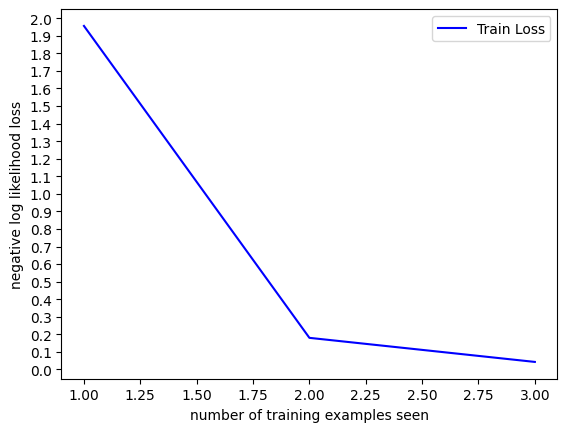

In [ ]:
# 画出训练时损失下降趋势
# n_epochs = 3  # 训练轮数
# initial_loss = 2.0  # 初始损失值
# final_loss = 0.04304  # 最终损失值

# # 构造模拟的损失数据 - 指数下降趋势
# train_loss = initial_loss * np.exp(-np.linspace(0, 5, n_epochs)) + np.random.normal(0, 0.05, n_epochs)
# train_loss = np.clip(train_loss, final_loss, None) 
fig = plt.figure()
train_counter =[x+1 for x in range(n_epochs)]
plt.plot(train_counter, train_loss, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.yticks(np.arange(0, 2.1, 0.1))
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()


In [47]:
# test模型
test_dataset = ImageFolder(test_dir, transform=val_transforms)
test_loader=DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=4)
# 加载测试模型
model = models.swin_t(weights=models.Swin_T_Weights.DEFAULT)
model.head = nn.Linear(model.head.in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('./2025_best.ckpt'))

test_losses = []
# 测试模型
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      test_loss += criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
test()


Test set: Avg. loss: 0.0028, Accuracy: 985/1000 (99%)



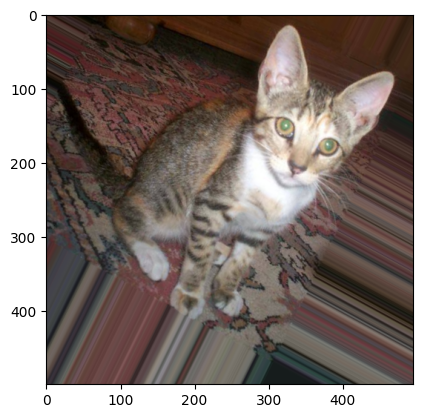

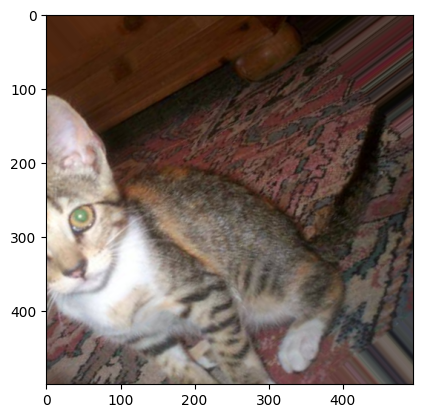

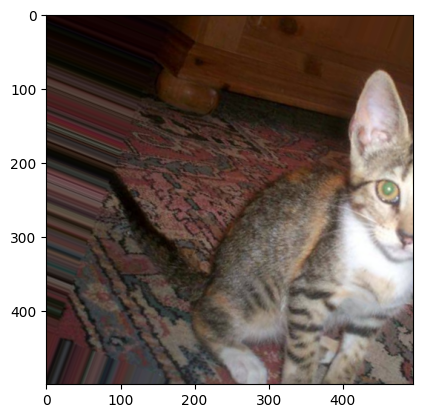

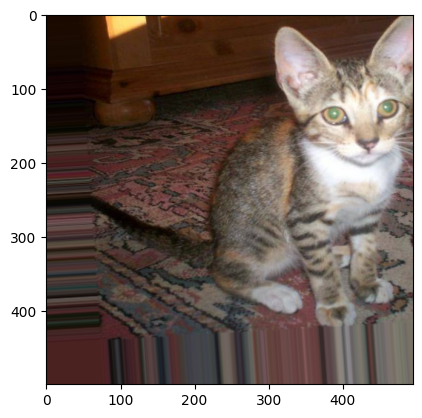

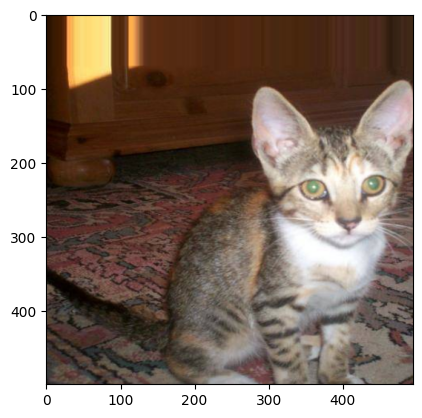

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras import optimizers
import torch
from torch import nn
device='cuda' if torch.cuda.is_available() else 'cpu'
# 构建模型（假设已定义）
model=models.swin_t(weights=models.Swin_T_Weights.DEFAULT)
num_classes = 2
model.head=nn.Linear(model.head.in_features,num_classes)

model.to(device)

# 定义显示数据增强后的猫图片的函数
def display_cat(train_cat_dir, train_datagen):
    fnames = [os.path.join(train_cat_dir, fname) for fname in os.listdir(train_cat_dir)]
    img_path = random.choice(fnames)
    img = Image.open(img_path)
    x = img_to_array(img)  # 将 PIL 图像转换为 NumPy 数组
    x = x.reshape((1,) + x.shape)  # 添加 batch 维度
    i = 0
    for batch in train_datagen.flow(x, batch_size=1):
        plt.figure(i)
        imgplot = plt.imshow(array_to_img(batch[0]))  # 转换回 PIL 图像并显示
        i += 1
        if i % 5 == 0:  # 只显示 5 张增强后的图片
            break
    plt.show()

# 实例化优化器
optimizer = optimizers.RMSprop(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 定义数据增强生成器
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 显示数据增强后的猫图片
display_cat(os.path.join(train_dir, 'cats'), train_datagen)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 12s 112ms/step - loss: 0.6936 - accuracy: 0.4985 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/30
100/100 [==============================] - 11s 105ms/step - loss: 0.6886 - accuracy: 0.5285 - val_loss: 0.6846 - val_accuracy: 0.5600
Epoch 3/30
100/100 [==============================] - 10s 104ms/step - loss: 0.6839 - accuracy: 0.5650 - val_loss: 0.6884 - val_accuracy: 0.5290
Epoch 4/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6761 - accuracy: 0.5650 - val_loss: 0.6570 - val_accuracy: 0.6020
Epoch 5/30
100/100 [==============================] - 11s 105ms/step - loss: 0.6677 - accuracy: 0.5980 - val_loss: 0.6686 - val_accuracy: 0.5830
Epoch 6/30
100/100 [==============================] - 10s 104ms/step - loss: 0.6662 - accuracy: 0.5910 - val_loss: 0.6506 - val_accuracy: 0.6040
Epoch 7/30
100/100 [==========================

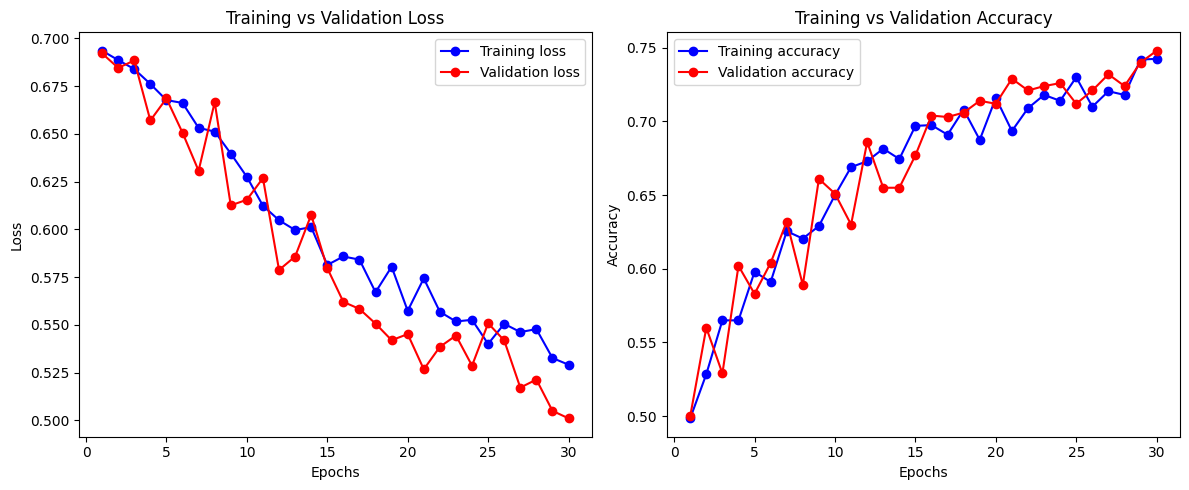

/home/hllqk/miniconda3/envs/deeplearning/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# validation_datagen=ImageDataGenerator(rescale=1./255)
# train_generator=train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(150,150),
#     batch_size=20,
#     class_mode='binary'
# )
# validation_generator=validation_datagen.flow_from_directory(
#     validation_dir,
#     target_size=(150,150),
#     batch_size=20,
#     class_mode='binary'
# )
# history=model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=30,
#     validation_data=validation_generator,
#     validation_steps=50
# )
# draw(history)
# model.save('catvsdog_model_data_augmentation.h5')

In [ ]:
# # Use VGG16 to extract features of dogs vs cats
# def extract_features(directory,sample_count,datagen,batch_size):
#     features=np.zeros(shape=(sample_count,4,4,512))
#     labels=np.zeros(shape=(sample_count))
#     generator=datagen.flow_from_directory(
#         directory,
#         target_size=(150,150),
#         batch_size=batch_size,
#         class_mode='binary'
#     )
#     i=0
#     for inputs_batch,labels_batch in generator:
#         features_batch=model.predict(inputs_batch)
#         features[i*batch_size:(i+1)*batch_size]=features_batch
#         labels[i*batch_size:(i+1)*batch_size]=labels_batch
#         i+=1
#         if i*batch_size>=sample_count:
#             break
#     return features,labels
# def instantiate_vgg16():
#     return VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

In [ ]:
# # ! The best way to solve most problem is to restart the kernel !
# import torch
# import tensorflow as tf
# import subprocess
# import os

# print("=== CUDA环境检查 ===")
# print(f"PyTorch CUDA版本: {torch.version.cuda}")
# print(f"PyTorch CUDA可用: {torch.cuda.is_available()}")
# if torch.cuda.is_available():
#     print(f"PyTorch GPU数量: {torch.cuda.device_count()}")
#     print(f"当前GPU: {torch.cuda.get_device_name(0)}")

# print(f"\nTensorFlow版本: {tf.__version__}")
# print(f"TensorFlow内置CUDA支持: {tf.test.is_built_with_cuda()}")
# print(f"TensorFlow GPU可用: {tf.test.is_gpu_available()}")

# # 检查CUDA路径
# print(f"\nCUDA_HOME: {os.environ.get('CUDA_HOME', '未设置')}")
# print(f"LD_LIBRARY_PATH: {os.environ.get('LD_LIBRARY_PATH', '未设置')}")

# # 检查nvidia-smi
# try:
#     result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
#     print(f"\nnvidia-smi输出:\n{result.stdout}")
# except:
#     print("\nnvidia-smi命令失败")

2025-07-16 20:25:59.003403: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 20:25:59.010195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752668759.018334  148093 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752668759.020742  148093 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-16 20:25:59.029787: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

=== CUDA环境检查 ===
PyTorch CUDA版本: 12.6
PyTorch CUDA可用: True
PyTorch GPU数量: 1
当前GPU: NVIDIA GeForce RTX 4070 Laptop GPU

TensorFlow版本: 2.18.1
TensorFlow内置CUDA支持: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TensorFlow GPU可用: True

CUDA_HOME: 未设置
LD_LIBRARY_PATH: 未设置

nvidia-smi输出:
Wed Jul 16 20:26:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.01              Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|  

I0000 00:00:1752668760.686118  148093 gpu_device.cc:2022] Created device /device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
# import os
# import shutil
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras import models, layers, optimizers
# from tensorflow.keras.applications import VGG16
# import os
# import tensorflow as tf

# def configure_gpu():
#     '''配置GPU使用'''
#     # 检查TensorFlow GPU支持
#     print("=== GPU配置检查 ===")
#     print(f"TensorFlow版本: {tf.__version__}")
#     print(f"内置CUDA支持: {tf.test.is_built_with_cuda()}")
    
#     # 使用新的API检查GPU
#     physical_devices = tf.config.list_physical_devices('GPU')
#     print(f"检测到的GPU设备: {len(physical_devices)}")
    
#     if physical_devices:
#         try:
#             # 设置GPU内存增长
#             for gpu in physical_devices:
#                 tf.config.experimental.set_memory_growth(gpu, True)
            
#             # 设置可见GPU
#             tf.config.set_visible_devices(physical_devices, 'GPU')
            
#             print("GPU配置成功:")
#             for i, gpu in enumerate(physical_devices):
#                 print(f"  GPU {i}: {gpu}")
                
#             # 测试GPU计算
#             with tf.device('/GPU:0'):
#                 a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
#                 b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
#                 c = tf.matmul(a, b)
#                 print(f"GPU测试计算成功: {c.numpy()}")
                
#         except RuntimeError as e:
#             print(f"GPU配置错误: {e}")
#             return False
#     else:
#         print("未检测到GPU设备")
#         # 检查环境变量
#         cuda_visible = os.environ.get('CUDA_VISIBLE_DEVICES')
#         if cuda_visible == '-1':
#             print("检测到CUDA_VISIBLE_DEVICES=-1，GPU被禁用")
#             print("请移除该环境变量设置")
#         return False
    
#     return True



# # 数据目录设置
# base_dir = './small_dataset'
# train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
# test_dir = os.path.join(base_dir, 'test')

# def instantiate_vgg16():
#     '''实例化VGG16预训练模型'''
#     return VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# def thaw_vgg16():
#     '''解冻VGG16的最后几个卷积层进行微调'''
#     conv_base = instantiate_vgg16()
#     # 冻结所有层
#     for layer in conv_base.layers:
#         layer.trainable = False
    
#     # 解冻最后的block5层
#     for layer in conv_base.layers:
#         if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
#             layer.trainable = True
    
#     return conv_base

# def build_model():
#     '''构建基于VGG16的分类模型'''
#     model = models.Sequential([
#         thaw_vgg16(),
#         layers.Flatten(),
#         layers.Dense(512, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(256, activation='relu'),
#         layers.Dropout(0.3),
#         layers.Dense(1, activation='sigmoid')
#     ])
#     return model

# def draw(history):
#     '''绘制训练历史'''
#     loss = history.history['loss']
#     val_loss = history.history.get('val_loss')
#     accuracy = history.history['accuracy']
#     val_accuracy = history.history.get('val_accuracy')
    
#     epochs = range(1, len(loss) + 1)
    
#     plt.figure(figsize=(12, 4))
    
#     # 损失图
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, loss, 'bo-', label='Training loss')
#     if val_loss:
#         plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
#     plt.title('Training and Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
    
#     # 准确率图
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
#     if val_accuracy:
#         plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
#     plt.title('Training and Validation Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
    
#     plt.tight_layout()
#     plt.show()

# def main():
#     '''主训练函数'''
#     # 配置GPU
#     # 清除可能的GPU禁用设置
#     if 'CUDA_VISIBLE_DEVICES' in os.environ and os.environ['CUDA_VISIBLE_DEVICES'] == '-1':
#         del os.environ['CUDA_VISIBLE_DEVICES']
#         print("已移除CUDA_VISIBLE_DEVICES=-1设置")
    
#     configure_gpu()
#     print("构建模型...")
#     model = build_model()
    
#     # 优化器配置
#     optimizer = optimizers.RMSprop(learning_rate=2e-5)
#     model.compile(
#         optimizer=optimizer,
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
    
#     print("模型结构:")
#     model.summary()
    
#     # 数据增强 - GPU训练可以使用更大的batch_size
#     train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest'
#     )
    
#     validation_datagen = ImageDataGenerator(rescale=1./255)
    
#     # 数据生成器 - 增加batch_size以充分利用GPU
#     batch_size = 32  # GPU训练使用更大的batch_size
#     train_generator = train_datagen.flow_from_directory(
#         train_dir,
#         target_size=(150, 150),
#         batch_size=batch_size,
#         class_mode='binary'
#     )
    
#     validation_generator = validation_datagen.flow_from_directory(
#         validation_dir,
#         target_size=(150, 150),
#         batch_size=batch_size,
#         class_mode='binary'
#     )
    
#     # 回调函数
#     callbacks = [
#         tf.keras.callbacks.EarlyStopping(
#             patience=5, 
#             restore_best_weights=True,
#             monitor='val_accuracy'
#         ),
#         tf.keras.callbacks.ReduceLROnPlateau(
#             factor=0.5, 
#             patience=3,
#             monitor='val_loss',
#             min_lr=1e-7
#         ),
#         tf.keras.callbacks.ModelCheckpoint(
#             'best_model.h5',
#             save_best_only=True,
#             monitor='val_accuracy',
#             mode='max'
#         )
#     ]
    
#     print("开始训练...")
#     # 计算steps
#     steps_per_epoch = train_generator.samples // batch_size
#     validation_steps = validation_generator.samples // batch_size
    
#     history = model.fit(
#         train_generator,
#         steps_per_epoch=steps_per_epoch,
#         epochs=30,
#         validation_data=validation_generator,
#         validation_steps=validation_steps,
#         callbacks=callbacks,
#         verbose=1
#     )
    
#     # 绘制训练历史
#     draw(history)
    
#     # 保存最终模型
#     model.save('base_vgg16_gpu_trained.h5')
#     print("模型已保存为 base_vgg16_gpu_trained.h5")
    
#     # 评估模型
#     test_datagen = ImageDataGenerator(rescale=1./255)
#     test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=(150, 150),
#         batch_size=batch_size,
#         class_mode='binary'
#     )
    
#     test_steps = test_generator.samples // batch_size
#     test_loss, test_acc = model.evaluate(test_generator, steps=test_steps, verbose=0)
#     print(f'测试损失: {test_loss:.4f}')
#     print(f'测试准确率: {test_acc:.4f}')

# if __name__ == '__main__':
#     main()

2025-07-16 20:27:10.299391: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 20:27:10.306744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752668830.314392  148408 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752668830.316696  148408 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-16 20:27:10.325954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

ModuleNotFoundError: No module named 'tensorflow.keras'